In [2]:


import numpy
print(numpy.__version__)

import sys
print(sys.version)

1.26.0
3.9.24 (main, Oct 21 2025, 20:14:38) [MSC v.1929 64 bit (AMD64)]


In [2]:
import torch
print(torch.__version__)

1.12.1+cu113


c:\Users\lucsc\anaconda3\envs\grad\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import dgl
print(dgl.__version__)

0.9.1


In [4]:
import dgl, torch
print("DGL:", dgl.__version__)
print("Torch:", torch.__version__)

DGL: 0.9.1
Torch: 1.12.1+cu113


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.transforms import GDC
from torch_geometric.nn import GCNConv
from sklearn.metrics import accuracy_score, roc_auc_score
from torch_geometric.utils import to_dense_adj, dense_to_sparse
from scipy.io import loadmat
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import scipy.io
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import networkx as nx

import numpy as np

from tqdm import tqdm

import argparse
import os

from utils.dataProcess import loadDataset, mergeGraphDataList, GDCAugment, data4WFusionTrain
from utils.MyUtils import color_print
from utils.args import argVar

from models.WeightedFusion import WeightFusion, WFusionTrain

In [8]:
import torch
syn_relation_filename = f"./Generation/SynRelation_amazon_100Samplesteps_6000Trainsteps_subgraphsize_32_guided.pt  "

gdc_aug_graph=torch.load(syn_relation_filename)


In [ ]:
def plot_graph(data, save_path="./plots", sample_nodes=None, figsize=(10, 8)):
    """
    Plots a PyTorch Geometric Data graph.

    Args:
        data: PyTorch Geometric Data object
        save_path: str or None, if provided, saves the plot to this path
        sample_nodes: int or None, if provided, randomly samples this many nodes for plotting
        figsize: tuple, size of the plot
    """
    G = nx.Graph()

    num_nodes = data.x.shape[0]

    # Optional node sampling for large graphs
    if sample_nodes and sample_nodes < num_nodes:
        import numpy as np
        sampled_nodes = np.random.choice(num_nodes, sample_nodes, replace=False)
        sampled_nodes_set = set(sampled_nodes)
        # Add sampled nodes
        for n in sampled_nodes:
            G.add_node(n)
        # Add edges where both nodes are in sampled set
        for i in range(data.edge_index.shape[1]):
            src = data.edge_index[0, i].item()
            dst = data.edge_index[1, i].item()
            if src in sampled_nodes_set and dst in sampled_nodes_set:
                G.add_edge(src, dst)
    else:
        # Add all nodes
        for i in range(num_nodes):
            G.add_node(i)
        # Add all edges
        for i in range(data.edge_index.shape[1]):
            src = data.edge_index[0, i].item()
            dst = data.edge_index[1, i].item()
            G.add_edge(src, dst)

    plt.figure(figsize=figsize)
    nx.draw(
        G,
        with_labels=False,  # large graphs look better without labels
        node_color='skyblue',
        edge_color='gray',
        node_size=50
    )

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300)
        plt.close()
    else:
        plt.show()

In [30]:
import os
import matplotlib.pyplot as plt
import networkx as nx
import dgl
    
def visualize_dgl_graph(graph, filename="graph_plot.png", max_nodes=500):
    """
    Visualize and save a DGL graph (or dict containing DGL graphs) as a PNG.

    Args:
        graph: DGLGraph, DGLHeteroGraph, or dict containing DGLGraph(s)
        filename: filename to save under 'plots' folder
        max_nodes: max number of nodes to display
    """


    # Create a folder to save plots
    os.makedirs("plots", exist_ok=True)

    for idx, data in enumerate(graph):
        # Create a NetworkX graph
        G = nx.Graph()

        # Add nodes
        for i in range(data.x.shape[0]):
            G.add_node(i)

        # Add edges
        edge_index = data.edge_index
        for i in range(edge_index.shape[1]):
            src = edge_index[0, i].item()
            dst = edge_index[1, i].item()
            G.add_edge(src, dst)

        # Draw the graph
        plt.figure(figsize=(8, 6))
        nx.draw(
            G, with_labels=True,
            node_color='skyblue',
            edge_color='gray',
            node_size=500
        )
        
        # Save the figure
        plt.savefig(f"plots/graph_{idx}.png")
        plt.close()  # Close the figure to free memory
        break



  0%|          | 0/1 [00:00<?, ?it/s]

passed here
Done loading data from cached files.
amazon_graph_dgl: 

Graph(num_nodes=11944, num_edges=9569592,
      ndata_schemes={'feature': Scheme(shape=(25,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool), '_ID': Scheme(shape=(), dtype=torch.int64), '_TYPE': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64), '_TYPE': Scheme(shape=(), dtype=torch.int64)})
amazon_graph_pyg: 

Data(x=[11944, 25], edge_index=[2, 9569592], y=[11944], train_mask=[11944], val_mask=[11944], test_mask=[11944])
train_val_test split

train_num: 3455; val_num: 2592; test_num: 2592
!!!!! Strat gdc augment



0it [00:00, ?it/s]
0it [00:00, ?it/s]

syn: Data(x=[11944, 25], edge_index=[2, 49947], y=[11944], train_mask=[11944], val_mask=[11944], test_mask=[11944])
aug: [Data(x=[32, 25], edge_index=[2, 91], y=[32], new_x=[32, 32], adj=[32, 32], train_mask=[32], val_mask=[32], test_mask=[32]), Data(x=[32, 25], edge_index=[2, 150], y=[32], new_x=[32, 32], adj=[32, 32], train_mask=[32], val_mask=[32], test_mask=[32]), Data(x=[32, 25], edge_index=[2, 98], y=[32], new_x=[32, 32], adj=[32, 32], train_mask=[32], val_mask=[32], test_mask=[32]), Data(x=[32, 25], edge_index=[2, 108], y=[32], new_x=[32, 32], adj=[32, 32], train_mask=[32], val_mask=[32], test_mask=[32]), Data(x=[32, 25], edge_index=[2, 101], y=[32], new_x=[32, 32], adj=[32, 32], train_mask=[32], val_mask=[32], test_mask=[32]), Data(x=[32, 25], edge_index=[2, 142], y=[32], new_x=[32, 32], adj=[32, 32], train_mask=[32], val_mask=[32], test_mask=[32]), Data(x=[32, 25], edge_index=[2, 119], y=[32], new_x=[32, 32], adj=[32, 32], train_mask=[32], val_mask=[32], test_mask=[32]), Data(


  0%|          | 0/1 [02:55<?, ?it/s]


FileNotFoundError: [WinError 3] Het systeem kan het opgegeven pad niet vinden: ''

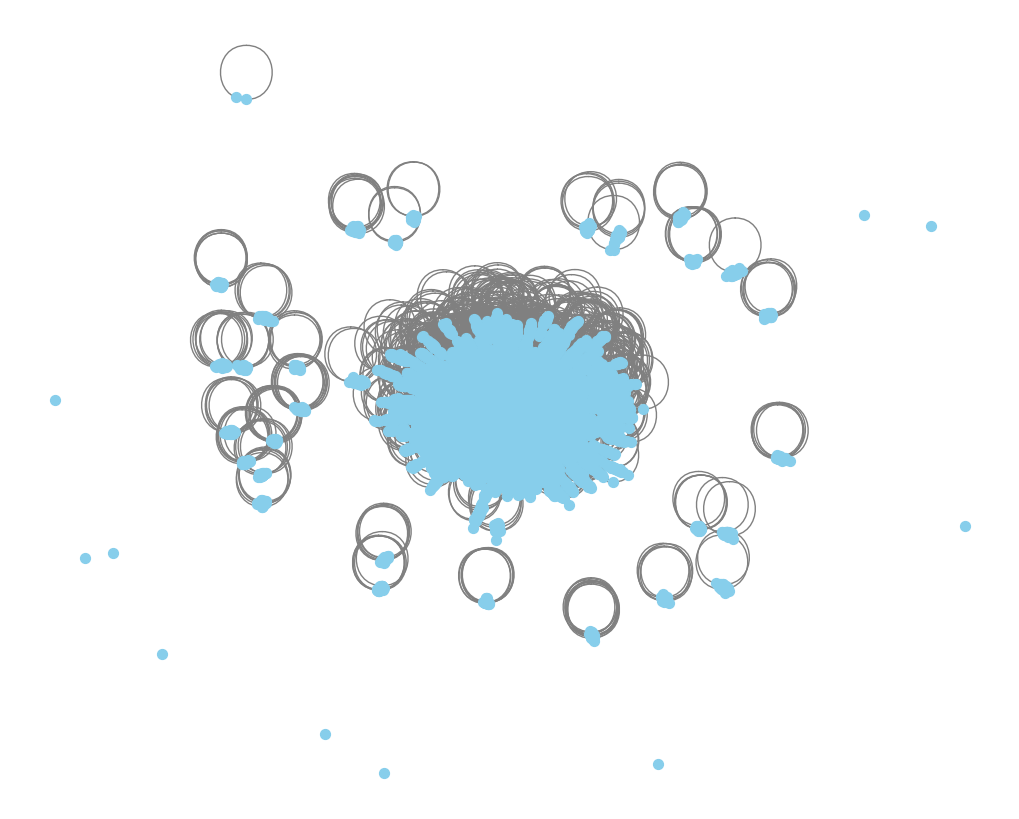

In [38]:
final_ap=[]
final_auc=[]
for i in tqdm((1,)):
    args = argVar()
    print(args)
    # prepare data
    print("passed here")
    graph_dgl, graph_pyg, train_mask, val_mask, test_mask = loadDataset(dataset=args.dataset, train_ratio=args.train_ratio)
    in_feats = graph_dgl.ndata['feature'].shape[1]
    num_classes = 2

    syn_relation_dict=torch.load(syn_relation_filename)

    graph_syn=mergeGraphDataList(args=args, graph_pyg=graph_pyg, syn_relation_dict=syn_relation_dict)

    color_print(f'!!!!! Strat gdc augment')
    graph_gdc_list=[]
    for avg_degree in tqdm(args.WFusion_gdc_syn_avg_degree):
        # filename=f'./Generation/GDCAugGraph/GDC_SynRelation_{args.dataset}_{args.GuiDDPM_sample_diffusion_steps}Samplesteps_{args.GuiDDPM_train_steps}Trainsteps_avgdegree_{avg_degree}.pt'
        filename = f"./Generation/SynRelation_amazon_100Samplesteps_6000Trainsteps_subgraphsize_32_guided.pt  "
        if os.path.exists(filename):
            gdc_aug_graph=torch.load(filename)

            color_print(f'gdc_aud{len(graph_gdc_list)+1} is load from {filename}') 
        else:
            gdc_aug_graph=GDCAugment(graph_pyg_type=graph_syn, avg_degree=avg_degree)
            torch.save(gdc_aug_graph,filename)
            color_print(f'gdc_aud{len(graph_gdc_list)+1} is saved in {filename}') 
        graph_gdc_list.append(gdc_aug_graph)

    for avg_degree in tqdm(args.WFusion_gdc_raw_avg_degree):
        # filename=f'./Generation/GDCAugGraph/GDC_RawRelation_{args.dataset}_{args.GuiDDPM_sample_diffusion_steps}Samplesteps_{args.GuiDDPM_train_steps}Trainsteps_avgdegree_{avg_degree}.pt'
        filename = f"./Generation/SynRelation_amazon_100Samplesteps_6000Trainsteps_subgraphsize_32_guided.pt  "

        if os.path.exists(filename):
            gdc_aug_graph=torch.load(filename)
            color_print(f'gdc_aud{len(graph_gdc_list)+1} is load from {filename}') 
        else:
            gdc_aug_graph=GDCAugment(graph_pyg_type=graph_pyg, avg_degree=avg_degree)
            torch.save(gdc_aug_graph,filename)
            color_print(f'gdc_aud{len(graph_gdc_list)+1} is saved in {filename}') 
        graph_gdc_list.append(gdc_aug_graph)
        
    print(f"syn: {graph_syn}")
    print(f"aug: {gdc_aug_graph['syn_relation_list']}")
    visualize_dgl_graph(gdc_aug_graph['syn_relation_list'], filename=f"gdc_aud{len(graph_gdc_list)+1}_graph.png")
    plot_graph(graph_syn)  
    break
    color_print(f'!!!!! Finish gdc augment')

    # graph_WFusion=data4WFusionTrain(graph_pyg=graph_pyg, 
    #                                 graph_syn=graph_syn, 
    #                                 graph_gdc_list=graph_gdc_list
    #                                 )

    # print(f"{graph_WFusion.ndata['feature'].shape}")

    # model_WFusion=WeightFusion(global_args=args, in_feats=graph_WFusion.ndata['feature'].shape[1], h_feats=args.WFusion_hid_dim, num_classes=num_classes, graph=graph_WFusion, d=args.WFusion_order, relations_idx=args.WFusion_relation_index, device=args.device).to(args.device)

    # auc,ap,losses_2,auc_2=WFusionTrain(model_WFusion, graph_WFusion, args,graph_WFusion.ndata['train_mask'],graph_WFusion.ndata['val_mask'],graph_WFusion.ndata['test_mask'])
    # final_ap.append(ap)
    # final_auc.append(auc)

    # color_print(f'auc:{final_auc}')
    # color_print(f'ap:{final_ap}')